In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import optuna

In [2]:
# Устанавливаем глобальное начальное состояние генератора случайных чисел
np.random.seed(42)

In [ ]:
df = pd.read_csv('data/df_cc50_iqr.csv')

In [4]:
# Найдем медиану по столбцу и добавим бинарное значение в датафрейм
median_cc50 = df['CC50'].median()
df['CC50_binary'] = (df['CC50'] > median_cc50).astype(int)

In [5]:
# Проверим баланс классов
df['CC50_binary'].value_counts()

CC50_binary
0    481
1    481
Name: count, dtype: int64

Анализ целевой переменной показал, что классы идеально сбалансированы. Применение методов коррекции не требуется.

In [ ]:
# Разделяем данные
X = df.drop(columns=['CC50', 'CC50_binary'])
y = df['CC50_binary']

In [8]:
# Делим исходные данные на тренировочную и тестовую выборки
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2)

Теперь необходимо выбрать оптимальную модель.

Для построения предсказательной модели были рассмотрены следующие алгоритмы:

* XGBClassifier;

* RandomForestClassifier;

* GradientBoostingClassifier;

* CatBoostClassifier;

* HistGradientBoostingClassifier;

* ExtraTreesClassifier.

In [9]:
    models = {
        'XGB': XGBClassifier( eval_metric='logloss'),
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'CatBoost': CatBoostClassifier(verbose=0),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'ExtraTrees': ExtraTreesClassifier()
    }

In [10]:
def evaluate_models(models, X_train_full, y_train_full, X_test, y_test):
    results = []

    for name, model in models.items():
        pipeline = Pipeline([
            ('classifier', model)
        ])

        pipeline.fit(X_train_full, y_train_full)
        y_pred = pipeline.predict(X_test)

        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        results.append({
            'Model': name,
            'Accuracy': round(accuracy, 4),
            'ROC_AUC': round(roc_auc, 4) if roc_auc is not None else None,
            'F1': round(f1, 4),
            'Tuned': False
        })

    return pd.DataFrame(results)
results_untuned = evaluate_models(models, X_train_full, y_train_full, X_test, y_test)
display(results_untuned)

,Model,Accuracy,ROC_AUC,F1,Tuned
0,XGB,0.8394,0.9180,0.8208,False
1,RandomForest,0.8031,0.8950,0.8041,False
2,GradientBoosting,0.8601,0.9271,0.8421,False
3,CatBoost,0.8394,0.9237,0.8229,False
4,HistGradientBoosting,0.8497,0.9169,0.8362,False
5,ExtraTrees,0.7824,0.8416,0.7835,False


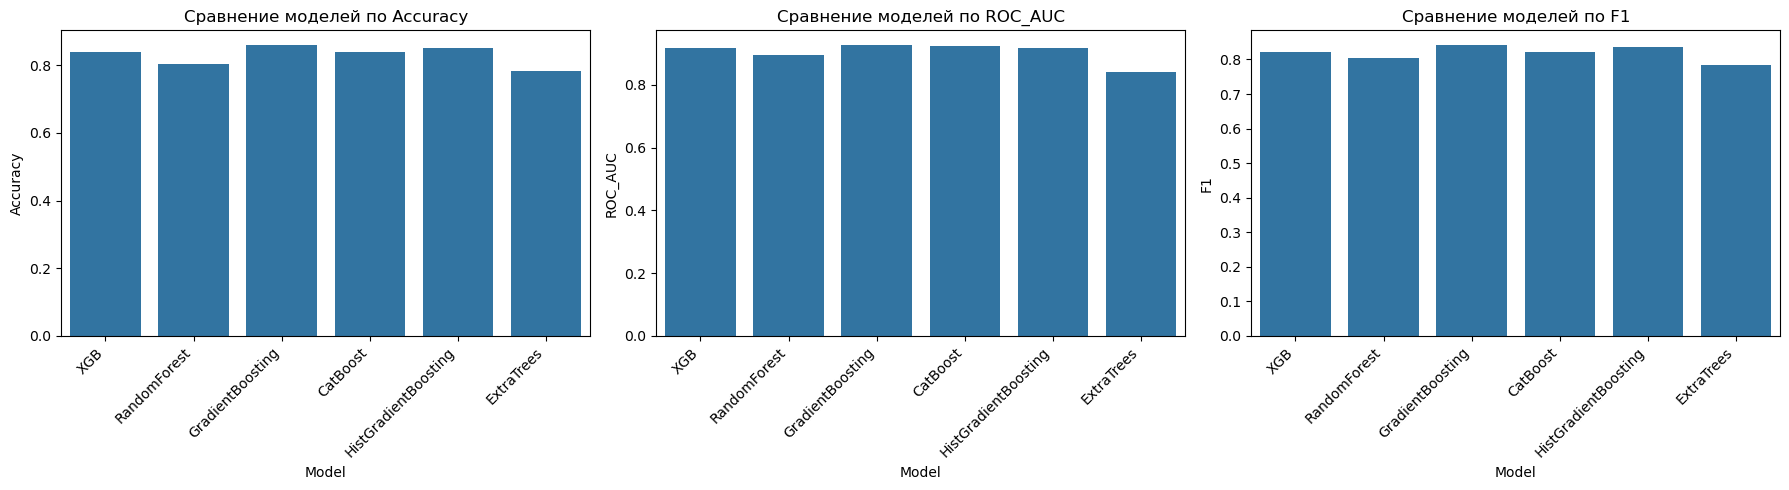

In [13]:
def plot_metrics_comparison(results_df):
    metrics = ['Accuracy', 'ROC_AUC', 'F1']
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, metric in enumerate(metrics):
        sns.barplot(data=results_df, x='Model', y=metric, ax=axs[i])
        axs[i].set_title(f'Сравнение моделей по {metric}')
        axs[i].set_xticks(range(len(results_df['Model'])))
        axs[i].set_xticklabels(results_df['Model'], rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

plot_metrics_comparison(results_untuned)

In [ ]:
def optuna_tuning(models, n_trials=50):
    results = []
    trained_models = {}

    # Проходим по всем моделям из переданного словаря
    for model_key, model in models.items():
        # Разбиваем данные на train/validation
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42
        )

        # Определяем функцию-цель для Optuna
        def objective(trial):
            # Для каждой модели формируем свой словарь параметров
            if model_key == 'XGB':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 500),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                    'gamma': trial.suggest_float('gamma', 0, 5),
                    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
                }
                reg = XGBClassifier(**params)

            elif model_key == 'RandomForest':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['log2', 'sqrt', None])
                }
                reg = RandomForestClassifier(**params)

            elif model_key == 'GradientBoosting':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
                }
                reg = GradientBoostingClassifier(**params, random_state=42)

            elif model_key == 'CatBoost':
                params = {
                    'iterations': trial.suggest_int('iterations', 100, 1000),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'depth': trial.suggest_int('depth', 4, 10),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1)
                }
                reg = CatBoostClassifier(**params, verbose=False)

            elif model_key == 'HistGradientBoosting':
                params = {
                    'max_iter': trial.suggest_int('max_iter', 50, 300),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'max_depth': trial.suggest_int('max_depth', 3, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
                    'l2_regularization': trial.suggest_float('l2_regularization', 0, 1)
                }
                reg = HistGradientBoostingClassifier(**params)

            elif model_key == 'ExtraTrees':
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 20),
                    'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                    'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                    'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
                }
                reg = ExtraTreesClassifier(**params)

            # Обучаем на train и проверяем accuracy_score на valid
            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_valid)
            return accuracy_score(y_valid, y_pred)

        # Запускаем оптимизацию Optuna
        study = optuna.create_study(direction='maximize')
        study.optimize(objective, n_trials=n_trials)

        # Формируем финальную модель с лучшими гиперпараметрами
        best_params = study.best_params

        if model_key == 'XGB':
            final_model = XGBClassifier(**best_params)

        elif model_key == 'RandomForest':
            final_model = RandomForestClassifier(**best_params)

        elif model_key == 'GradientBoosting':
            final_model = GradientBoostingClassifier(**best_params)

        elif model_key == 'CatBoost':
            final_model = CatBoostClassifier(**best_params, verbose=False)

        elif model_key == 'HistGradientBoosting':
            final_model = HistGradientBoostingClassifier(**best_params)

        elif model_key == 'ExtraTrees':
            final_model = ExtraTreesClassifier(**best_params)

        # Обучаем финальную модель на полном тренировочном наборе
        final_model.fit(X_train_full, y_train_full)

        # Сохраняем обученную модель в словарь trained_models
        trained_models[model_key] = final_model

        # Оцениваем финальную модель на тестовом наборе
        y_test_pred = final_model.predict(X_test)
        y_test_proba = final_model.predict_proba(X_test)[:, 1]
        
        test_f1 = f1_score(y_test, y_test_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_roc_auc = roc_auc_score(y_test, y_test_proba)

        # Сохраняем метрики в список results
        results.append({
            'Model': model_key,
            'F1': round(test_f1, 4),
            'Accuracy': round(test_accuracy, 4),
            'ROC_AUC': round(test_roc_auc, 4),
            'Tuned': True
        })

    # Превращаем список результатов в DataFrame
    results_tuned = pd.DataFrame(results)

    # Возвращаем две структуры: DataFrame и словарь обученных моделей
    return results_tuned, trained_models

In [15]:
results_tuned, trained_models = optuna_tuning(models)

[I 2025-06-02 20:17:06,069] A new study created in memory with name: no-name-d170e02d-c5f7-48e3-9ef3-bcc28704e418
[I 2025-06-02 20:17:06,439] Trial 0 finished with value: 0.8181818181818182 and parameters: {'n_estimators': 221, 'max_depth': 8, 'learning_rate': 0.29001088829760496, 'subsample': 0.6900833526095208, 'colsample_bytree': 0.7364620695466332, 'gamma': 0.3100993653075679, 'min_child_weight': 8}. Best is trial 0 with value: 0.8181818181818182.
[I 2025-06-02 20:17:06,647] Trial 1 finished with value: 0.8311688311688312 and parameters: {'n_estimators': 302, 'max_depth': 4, 'learning_rate': 0.2985348477673811, 'subsample': 0.9078035694836103, 'colsample_bytree': 0.9164038784657569, 'gamma': 2.016403511370803, 'min_child_weight': 4}. Best is trial 1 with value: 0.8311688311688312.
[I 2025-06-02 20:17:06,983] Trial 2 finished with value: 0.8376623376623377 and parameters: {'n_estimators': 493, 'max_depth': 8, 'learning_rate': 0.26248910168099865, 'subsample': 0.6745288010406814, 'co

In [16]:
results_tuned

,Model,F1,Accuracy,ROC_AUC,Tuned
0,XGB,0.8523,0.8653,0.9256,True
1,RandomForest,0.8304,0.8497,0.9177,True
2,GradientBoosting,0.8249,0.8394,0.9166,True
3,CatBoost,0.8242,0.8342,0.9164,True
4,HistGradientBoosting,0.8372,0.8549,0.9252,True
5,ExtraTrees,0.8256,0.8446,0.9159,True


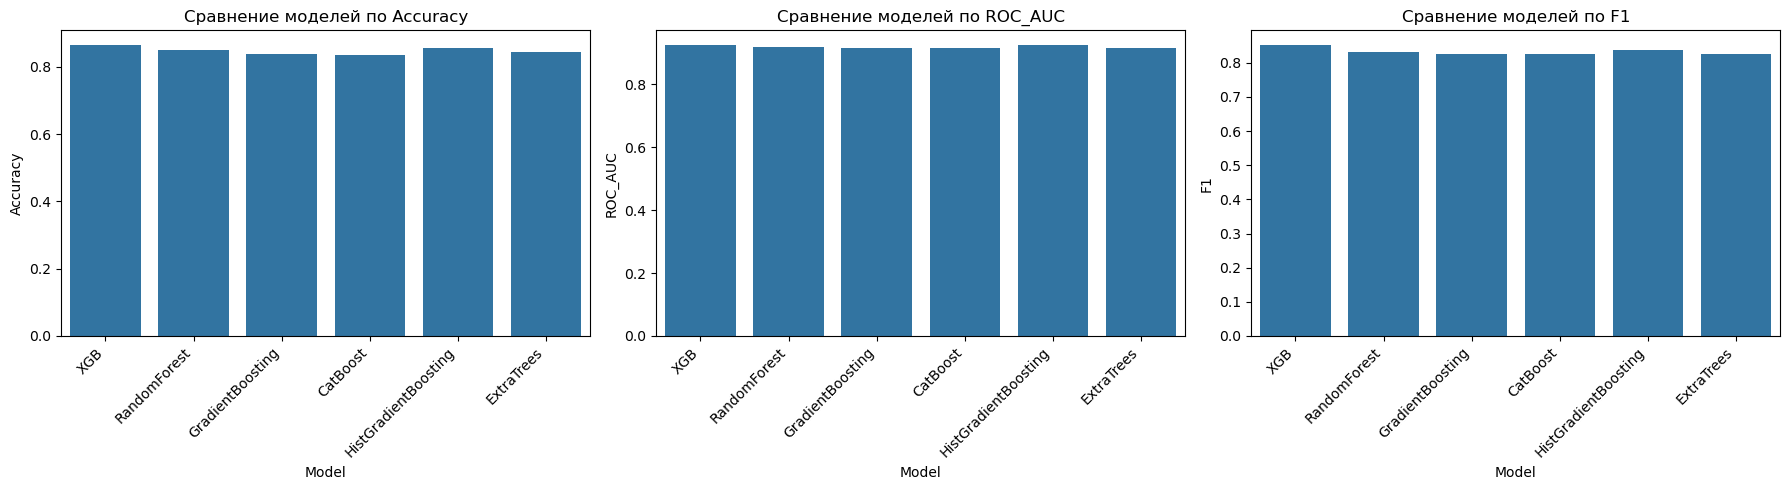

In [18]:
plot_metrics_comparison(results_tuned)

In [ ]:
combined_results = pd.concat([results_untuned, results_tuned], ignore_index=True)
display(combined_results.sort_values(by=["Accuracy"], ascending=False))

,Model,Accuracy,ROC_AUC,F1,Tuned
6,XGB,0.8653,0.9256,0.8523,True
2,GradientBoosting,0.8601,0.9271,0.8421,False
10,HistGradientBoosting,0.8549,0.9252,0.8372,True
7,RandomForest,0.8497,0.9177,0.8304,True
4,HistGradientBoosting,0.8497,0.9169,0.8362,False
11,ExtraTrees,0.8446,0.9159,0.8256,True
0,XGB,0.8394,0.9180,0.8208,False
3,CatBoost,0.8394,0.9237,0.8229,False
8,GradientBoosting,0.8394,0.9166,0.8249,True
9,CatBoost,0.8342,0.9164,0.8242,True


<Figure size 1500x500 with 0 Axes>

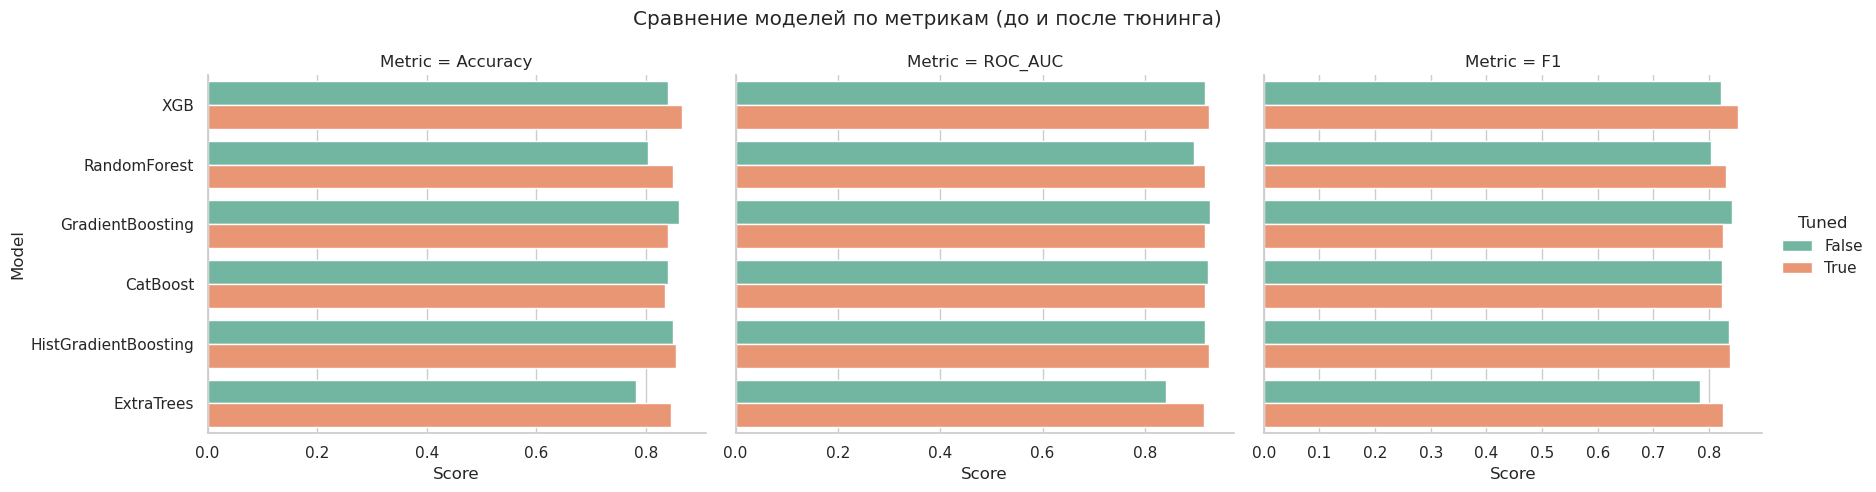

In [20]:
def plot_all_metrics(combined_results):
    melted = combined_results.melt(
        id_vars=["Model", "Tuned"],
        value_vars=['Accuracy', 'ROC_AUC', 'F1'],
        var_name="Metric",
        value_name="Score"
    )

    plt.figure(figsize=(15, 5))
    sns.set(style="whitegrid")

    g = sns.catplot(
        data=melted,
        x="Score",
        y="Model",
        hue="Tuned",
        col="Metric",
        kind="bar",
        palette="Set2",
        sharex=False,
        height=5,
        aspect=1.2
    )

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle("Сравнение моделей по метрикам (до и после тюнинга)")
    plt.show()
plot_all_metrics(combined_results)